# Assignment 1 - Build a Bayesian network in pyAgrum
In this assignment, part of the Bayesian Reasoning and Learning course of the master Artificial Intelligence of the Open Universiteit, I will be building a Bayesian network (BN) in pyAgrum. As I have been active in athletics since I was about 7 years old, I was curious as to how BNs are applicable in that domain. In this assignment I will therefore be investigating the possibilities of using BNs to predict sport injuries.

In [66]:
%pip install pyagrum
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [67]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pandas as pd

## Creating the BN
First I will create the BN, including all arcs and CPTs.

In [68]:
bn = gum.BayesNet('SportInjury')

In [69]:
# Create nodes
bn.add(gum.LabelizedVariable('Injury', 'Injury', ['Yes', 'No']))
bn.add(gum.LabelizedVariable('Age', 'Age', ['younger_than_12', '12_up_to_20', '20_up_to_35', 'older_than_35']))
bn.add(gum.LabelizedVariable('Training_intensity', 'Training type', ['High', 'Low']))
bn.add(gum.LabelizedVariable('Training_frequency', 'Training_frequency', ['up_till_3_per_week', 'more_than_3_per_week']))
bn.add(gum.LabelizedVariable('Too_much_training_causing_exhaustion', 'Too_much_training_causing_exhaustion', ['Yes', 'No'])) # Hidden node for the noisy OR
bn.add(gum.LabelizedVariable('Required_recovery_time', 'Required_recovery_time', ['Short', 'Long']))
bn.add(gum.LabelizedVariable('Sleep_quality', 'Sleep_quality', ['Good', 'Poor']))
bn.add(gum.LabelizedVariable('Sleep_quality_causing_exhaustion', 'Sleep_quality_causing_exhaustion', ['Yes', 'No'])) # Hidden node for the noisy OR
bn.add(gum.LabelizedVariable('Exhaustion', 'Exhaustion', ['Yes', 'No'])) # Will be a noisy OR
bn.add(gum.LabelizedVariable('Too_much_training', 'Too_much_training', ['Yes', 'No'])) # Will be a noisy AND

9

In [70]:
# Add arcs
arcs = [
    ('Age', 'Injury'),
    ('Age', 'Required_recovery_time'),
    ('Training_intensity', 'Injury'),
    ('Training_intensity', 'Required_recovery_time'),
    ('Training_frequency', 'Too_much_training'),
    ('Required_recovery_time', 'Too_much_training'),
    ('Sleep_quality', 'Sleep_quality_causing_exhaustion'),
    ('Too_much_training', 'Too_much_training_causing_exhaustion'),
    ('Sleep_quality_causing_exhaustion', 'Exhaustion'),
    ('Too_much_training_causing_exhaustion', 'Exhaustion'),
    ('Exhaustion', 'Injury')
]

for arc in arcs:
    bn.addArc(*arc)

bn

(pyagrum.BayesNet@0000029823537860) BN{nodes: 10, arcs: 11, domainSize: 2048, dim: 42, mem: 656o}

In [71]:
# Fill the conditional probability tables (CPTs)
bn.cpt('Age')[:] = [0.45, 0.45, 0.05, 0.05]
bn.cpt('Training_intensity')[:] = [0.2, 0.8]
bn.cpt('Training_frequency')[:] = [0.85, 0.15]
bn.cpt('Sleep_quality')[:] = [0.8, 0.2]

# Required_recovery_time is a conditional probability table based on age and Training_intensity
bn.cpt('Required_recovery_time')[{'Age': 'younger_than_12', 'Training_intensity': 'Low'}] = [0.95, 0.05]
bn.cpt('Required_recovery_time')[{'Age': 'younger_than_12', 'Training_intensity': 'High'}] = [0.8, 0.2]
bn.cpt('Required_recovery_time')[{'Age': '12_up_to_20', 'Training_intensity': 'Low'}] = [0.9, 0.1]
bn.cpt('Required_recovery_time')[{'Age': '12_up_to_20', 'Training_intensity': 'High'}] = [0.75, 0.25]
bn.cpt('Required_recovery_time')[{'Age': '20_up_to_35', 'Training_intensity': 'Low'}] = [0.85, 0.15]
bn.cpt('Required_recovery_time')[{'Age': '20_up_to_35', 'Training_intensity': 'High'}] = [0.7, 0.3]
bn.cpt('Required_recovery_time')[{'Age': 'older_than_35', 'Training_intensity': 'Low'}] = [0.75, 0.25]
bn.cpt('Required_recovery_time')[{'Age': 'older_than_35', 'Training_intensity': 'High'}] = [0.6, 0.4]

# Too_much_training is a noisy AND of Training_frequency and Required_recovery_time
bn.cpt('Too_much_training')[{'Training_frequency': 'up_till_3_per_week', 'Required_recovery_time': 'Short'}] = [0.05, 0.95]
bn.cpt('Too_much_training')[{'Training_frequency': 'up_till_3_per_week', 'Required_recovery_time': 'Long'}] = [0.05, 0.95]
bn.cpt('Too_much_training')[{'Training_frequency': 'more_than_3_per_week', 'Required_recovery_time': 'Short'}] = [0.05, 0.95]
bn.cpt('Too_much_training')[{'Training_frequency': 'more_than_3_per_week', 'Required_recovery_time': 'Long'}] = [0.95, 0.05]

# Exhaustion is a noisy OR of Sleep_quality and Too_much_training
bn.cpt('Exhaustion')[{'Sleep_quality_causing_exhaustion': 'Yes', 'Too_much_training_causing_exhaustion': 'Yes'}] = [1.0, 0.0]
bn.cpt('Exhaustion')[{'Sleep_quality_causing_exhaustion': 'Yes', 'Too_much_training_causing_exhaustion': 'No'}] = [1.0, 0.0]
bn.cpt('Exhaustion')[{'Sleep_quality_causing_exhaustion': 'No', 'Too_much_training_causing_exhaustion': 'Yes'}] = [1.0, 0.0]
bn.cpt('Exhaustion')[{'Sleep_quality_causing_exhaustion': 'No', 'Too_much_training_causing_exhaustion': 'No'}] = [0.0, 1.0]
# Hidden nodes for the noisy OR
bn.cpt('Sleep_quality_causing_exhaustion')[{'Sleep_quality': 'Good'}] = [0.05, 0.95] 
bn.cpt('Sleep_quality_causing_exhaustion')[{'Sleep_quality': 'Poor'}] = [0.95, 0.05]
bn.cpt('Too_much_training_causing_exhaustion')[{'Too_much_training': 'Yes'}] = [0.95, 0.05]
bn.cpt('Too_much_training_causing_exhaustion')[{'Too_much_training': 'No'}] = [0.05, 0.95]

# Injury is a combination of age, Training_intensity and exhaustion
bn.cpt('Injury')[{'Age': 'younger_than_12', 'Training_intensity': 'Low', 'Exhaustion': 'No'}] = [0.03, 0.97]
bn.cpt('Injury')[{'Age': 'younger_than_12', 'Training_intensity': 'Low', 'Exhaustion': 'Yes'}] = [0.10, 0.90]
bn.cpt('Injury')[{'Age': 'younger_than_12', 'Training_intensity': 'High', 'Exhaustion': 'No'}] = [0.10, 0.90]
bn.cpt('Injury')[{'Age': 'younger_than_12', 'Training_intensity': 'High', 'Exhaustion': 'Yes'}] = [0.30, 0.70]

bn.cpt('Injury')[{'Age': '12_up_to_20', 'Training_intensity': 'Low', 'Exhaustion': 'No'}] = [0.05, 0.95]
bn.cpt('Injury')[{'Age': '12_up_to_20', 'Training_intensity': 'Low', 'Exhaustion': 'Yes'}] = [0.20, 0.80]
bn.cpt('Injury')[{'Age': '12_up_to_20', 'Training_intensity': 'High', 'Exhaustion': 'No'}] = [0.20, 0.80]
bn.cpt('Injury')[{'Age': '12_up_to_20', 'Training_intensity': 'High', 'Exhaustion': 'Yes'}] = [0.40, 0.60]

bn.cpt('Injury')[{'Age': '20_up_to_35', 'Training_intensity': 'Low', 'Exhaustion': 'No'}] = [0.10, 0.90]
bn.cpt('Injury')[{'Age': '20_up_to_35', 'Training_intensity': 'Low', 'Exhaustion': 'Yes'}] = [0.25, 0.75]
bn.cpt('Injury')[{'Age': '20_up_to_35', 'Training_intensity': 'High', 'Exhaustion': 'No'}] = [0.25, 0.75]
bn.cpt('Injury')[{'Age': '20_up_to_35', 'Training_intensity': 'High', 'Exhaustion': 'Yes'}] = [0.45, 0.55]

bn.cpt('Injury')[{'Age': 'older_than_35', 'Training_intensity': 'Low', 'Exhaustion': 'No'}] = [0.15, 0.85]
bn.cpt('Injury')[{'Age': 'older_than_35', 'Training_intensity': 'Low', 'Exhaustion': 'Yes'}] = [0.35, 0.65]
bn.cpt('Injury')[{'Age': 'older_than_35', 'Training_intensity': 'High', 'Exhaustion': 'No'}] = [0.35, 0.65]
bn.cpt('Injury')[{'Age': 'older_than_35', 'Training_intensity': 'High', 'Exhaustion': 'Yes'}] = [0.55, 0.45]


In [72]:
for node in bn.nodes():
    gnb.sideBySide(bn.cpt(node))

## Inference
With the BN built, we can start looking at the priors and posteriors.

In [73]:
ie = gum.LazyPropagation(bn)

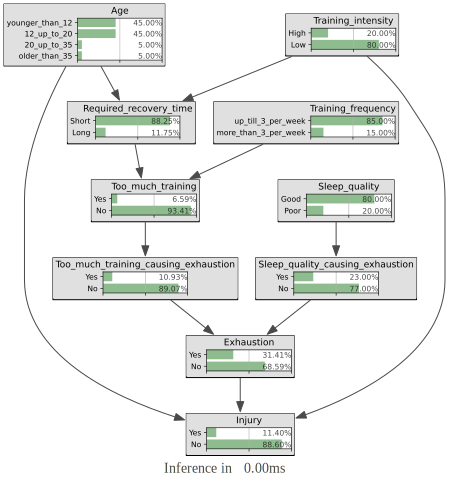

In [74]:
gnb.showInference(bn,evs={})

As an example, let's say we know a person is older_than_35, is doing a low-intensity training, trains more than 3 times each week but has poor sleep. What is the probability of injury?

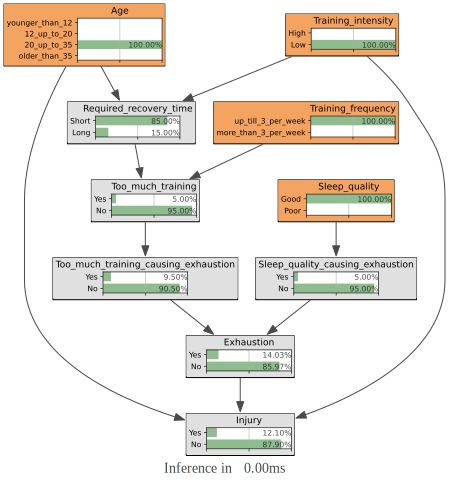

In [75]:
gnb.showInference(bn, evs={'Age': '20_up_to_35', 'Training_intensity': 'Low', 'Training_frequency': 'up_till_3_per_week', 'Sleep_quality': 'Good'})

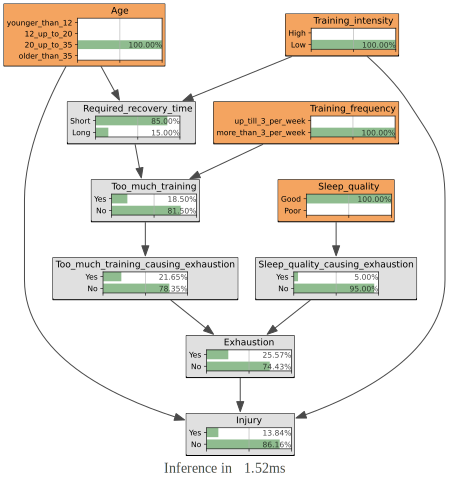

In [76]:
gnb.showInference(bn, evs={'Age': '20_up_to_35', 'Training_intensity': 'Low', 'Training_frequency': 'more_than_3_per_week', 'Sleep_quality': 'Good'})

# Generation of database and export
For the second assignment, it is required to generate data based on our BN. We also need the BN exported for future use.

In [81]:
for sample_size in [50, 100, 500, 1000, 2_000, 5_000, 10_000]:
    gum.generateSample(bn, sample_size, f'data/sport_injury_{sample_size}.csv')

gum.saveBN(bn, 'data/sport_injury.net')
